In [1]:
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
from IPython.core.debugger import set_trace

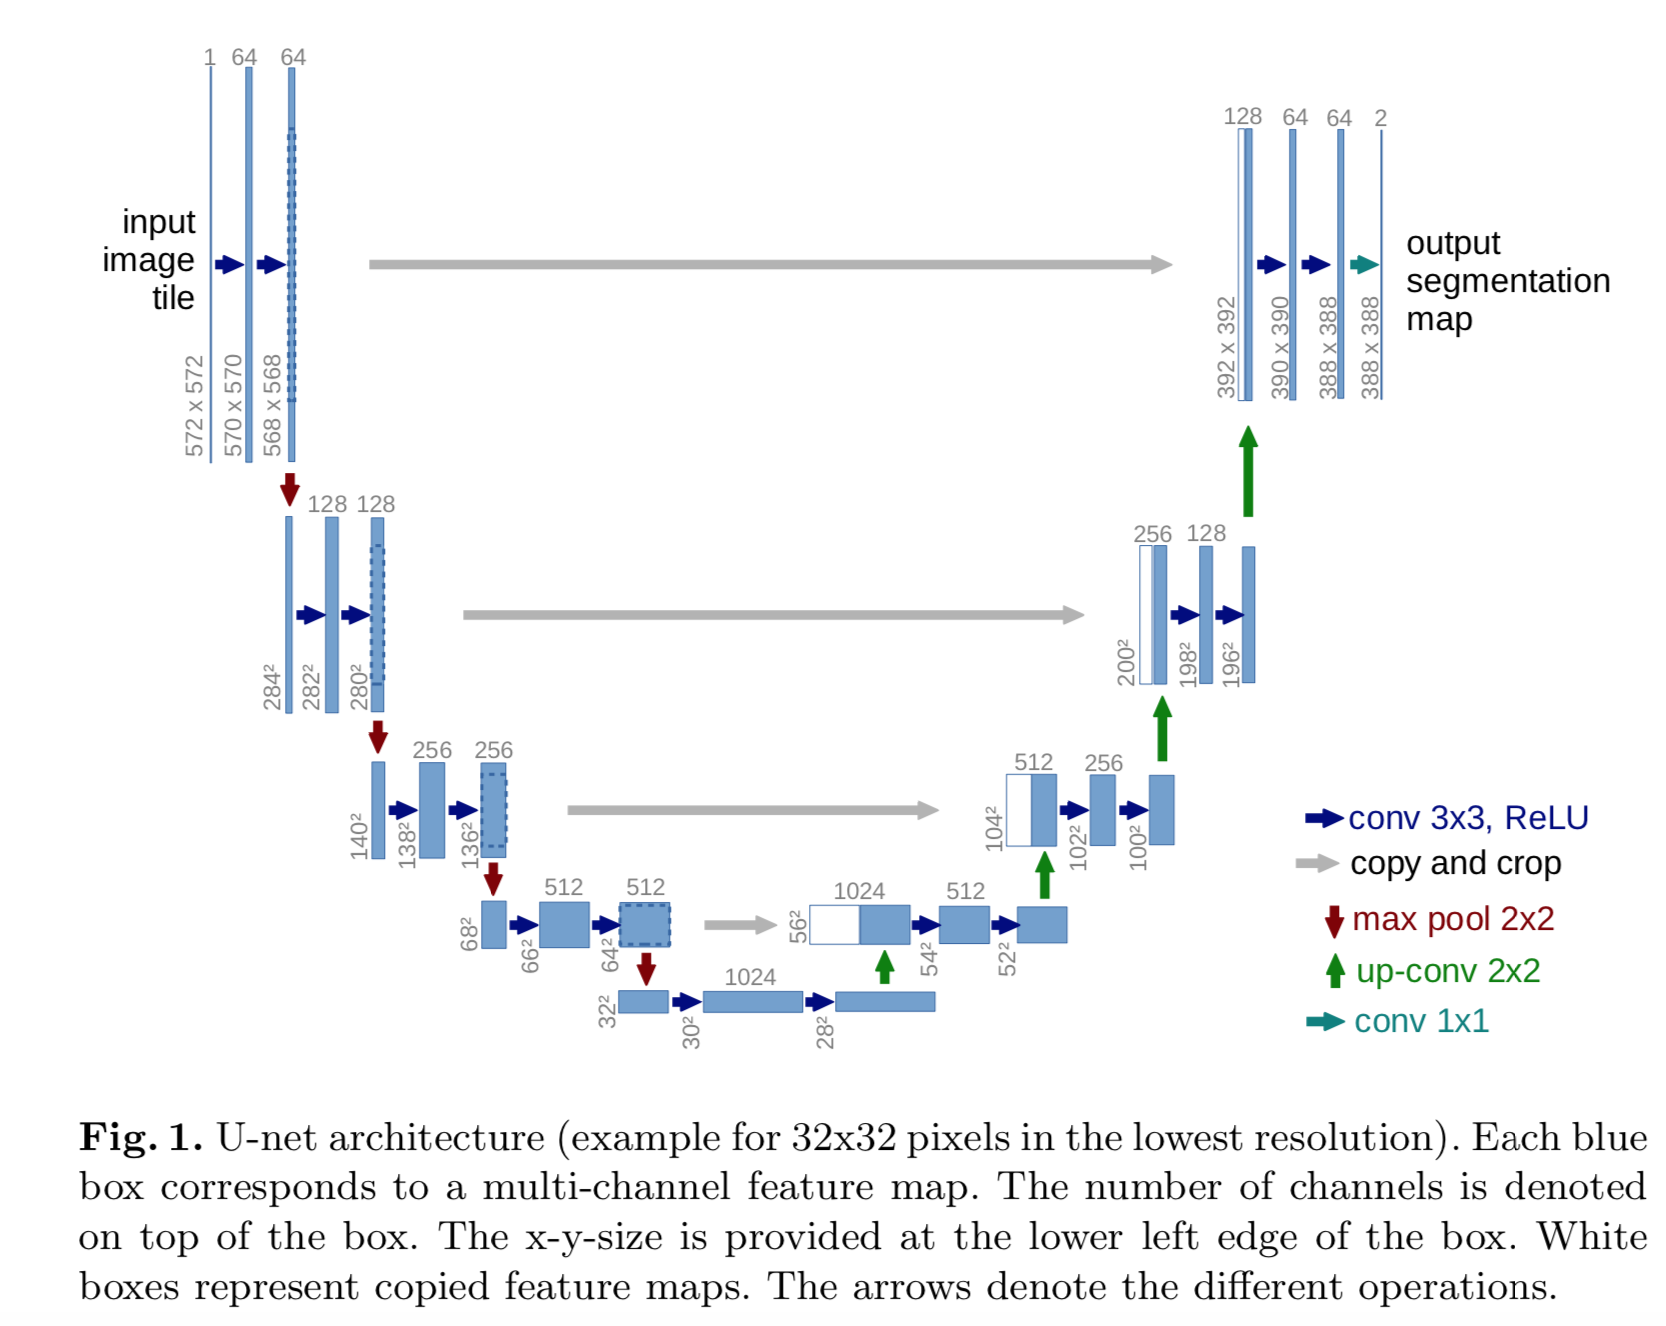

In [2]:
Image.open('network visualize.png')

In [3]:
def contracting_block(in_channels, out_channels):
    block = torch.nn.Sequential(
        nn.Conv2d(kernel_size=(3,3), in_channels=in_channels, out_channels=out_channels),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels),
        nn.Conv2d(kernel_size=(3,3), in_channels=out_channels, out_channels=out_channels),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels)
    )
    return block

class expansive_block(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super(expansive_block, self).__init__()
        
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=(3,3), stride=2, padding=1, 
                                     output_padding=1)
        self.block = nn.Sequential(
            nn.Conv2d(kernel_size=(3,3), in_channels=in_channels, out_channels=mid_channels),
            nn.ReLU(),
            nn.BatchNorm2d(mid_channels),
            nn.Conv2d(kernel_size=(3,3), in_channels=mid_channels, out_channels=out_channels),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels)
        )
    
    def forward(self, e, d):
        d = self.up(d)
        #concat
        diffY = e.size()[2]-d.size()[2]
        diffX = e.size()[3]-d.size()[3]
        e = e[:,:, diffY//2:e.size()[2]-diffY//2, diffX//2:e.size()[3]-diffX//2]
        cat = torch.cat([e, d], dim=1)
        out = self.block(cat)
        return out

def final_block(in_channels, out_channels):
    block = nn.Sequential(
        nn.Conv2d(kernel_size=(1,1), in_channels=in_channels, out_channels=out_channels),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels),
    )
    return block

class UNet(nn.Module):
    
    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        #Encode
        self.conv_encode1 = contracting_block(in_channels=in_channel, out_channels=64)
        self.conv_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_encode2 = contracting_block(in_channels=64, out_channels=128)
        self.conv_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_encode3 = contracting_block(in_channels=128, out_channels=256)
        self.conv_pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_encode4 = contracting_block(in_channels=256, out_channels=512)
        self.conv_pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        #Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(kernel_size=(3,3), in_channels=512, out_channels=1024),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            nn.Conv2d(kernel_size=(3,3), in_channels=1024, out_channels=1024),
            nn.ReLU(),
            nn.BatchNorm2d(1024)
        )
        
        # Decode
        self.conv_decode4 = expansive_block(1024, 512, 512)
        self.conv_decode3 = expansive_block(512, 256, 256)
        self.conv_decode2 = expansive_block(256, 128, 128)
        self.conv_decode1 = expansive_block(128, 64, 64)
        
        self.final_layer = final_block(64, out_channel)
    
    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x);print('encode_block1:', encode_block1.size())
        encode_pool1 = self.conv_pool1(encode_block1);print('encode_pool1:', encode_pool1.size())
        encode_block2 = self.conv_encode2(encode_pool1);print('encode_block2:', encode_block2.size())
        encode_pool2 = self.conv_pool2(encode_block2);print('encode_pool2:', encode_pool2.size())
        encode_block3 = self.conv_encode3(encode_pool2);print('encode_block3:', encode_block3.size())
        encode_pool3 = self.conv_pool3(encode_block3);print('encode_pool3:', encode_pool3.size())
        encode_block4 = self.conv_encode4(encode_pool3);print('encode_block4:', encode_block4.size())
        encode_pool4 = self.conv_pool4(encode_block4);print('encode_pool4:', encode_pool4.size())

        # Bottleneck
        bottleneck = self.bottleneck(encode_pool4);print('bottleneck:', bottleneck.size())
        
        # Decode
        decode_block4 = self.conv_decode4(encode_block4, bottleneck);print('decode_block4:', decode_block4.size())
        decode_block3 = self.conv_decode3(encode_block3, decode_block4);print('decode_block3:', decode_block3.size())
        decode_block2 = self.conv_decode2(encode_block2, decode_block3);print('decode_block2:', decode_block2.size())
        decode_block1 = self.conv_decode1(encode_block1, decode_block2);print('decode_block1:', decode_block1.size())
        
        final_layer = self.final_layer(decode_block1)
        return final_layer

In [4]:
image = torch.rand((1, 3, 572, 572))
image.size()

torch.Size([1, 3, 572, 572])

In [5]:
unet = UNet(in_channel=3, out_channel=1)

In [6]:
mask = unet(image)

encode_block1: torch.Size([1, 64, 568, 568])
encode_pool1: torch.Size([1, 64, 284, 284])
encode_block2: torch.Size([1, 128, 280, 280])
encode_pool2: torch.Size([1, 128, 140, 140])
encode_block3: torch.Size([1, 256, 136, 136])
encode_pool3: torch.Size([1, 256, 68, 68])
encode_block4: torch.Size([1, 512, 64, 64])
encode_pool4: torch.Size([1, 512, 32, 32])
bottleneck: torch.Size([1, 1024, 28, 28])
decode_block4: torch.Size([1, 512, 52, 52])
decode_block3: torch.Size([1, 256, 100, 100])
decode_block2: torch.Size([1, 128, 196, 196])
decode_block1: torch.Size([1, 64, 388, 388])
